In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
words = open('names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
len(words)

32033

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i +1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(stoi, itos)
print(vocab_size)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} {1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
block_size = 3

def build_dataset(words):
    X,Y = [],[]
    for w in words:
        context = [0] * block_size
        for ch in w + '.': 
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape,Y.shape)
    return X,Y
    
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
#MLP revisited

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),			generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),	generator=g) * (5/3)/((n_embd * block_size)**0.5 )
#b1 = torch.randn(n_hidden,						generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),			generator=g) * 0.01
b2 = torch.randn(vocab_size,					generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C,W1,W2,b2,bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True


12097


In [19]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
	ix = torch.randint(0, Xtr.shape[0], (batch_size,),	generator=g)
	Xb, Yb = Xtr[ix], Ytr[ix]

	emb = C[Xb]
	embcat = emb.view(emb.shape[0], -1)
	hpreact = embcat @ W1 #+ b1
	bnmeani = hpreact.mean(0, keepdim=True)
	bnstdi = hpreact.std(0, keepdim=True)
	hpreact = bngain * ((hpreact - bnmeani)/bnstdi) + bnbias

	with torch.no_grad():
		bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
		bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

	h = torch.tanh(hpreact)
	logits = h @ W2 + b2
	loss = F.cross_entropy(logits, Yb)

	for p in parameters:
		p.grad = None
	
	loss.backward()

	lr = 0.1 if i<100000 else 0.01
	for p in parameters:
		p.data += -lr * p.grad
	
	if i%10000 == 0:
		print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
	lossi.append(loss.log10().item())
	#break
 

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


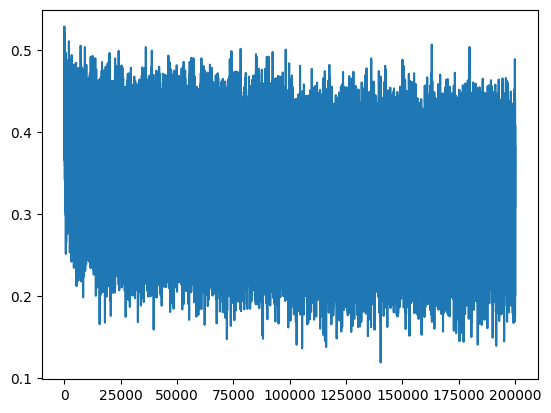

In [18]:
plt.plot(lossi)

In [82]:
logits[0]

tensor([-0.0560,  0.0099,  0.0366,  0.0810,  0.0528, -0.0157, -0.0499, -0.0114,
        -0.0157, -0.0415, -0.0464,  0.1354,  0.0250,  0.0438, -0.0091,  0.1373,
         0.0970,  0.0030,  0.1898, -0.0161,  0.0565, -0.0257,  0.1056,  0.1342,
         0.0203, -0.0749, -0.0304], grad_fn=<SelectBackward0>)

(array([ 85., 151., 118., 129., 117., 147., 151., 139., 144., 170.,  95.,
        147., 135., 124., 122., 103., 132., 137., 107., 112., 146.,  93.,
        116., 119., 120., 151., 119., 128., 106., 124., 101., 117., 102.,
        110., 120., 112., 116., 109., 135., 179., 142., 132., 142., 140.,
        162., 139., 134., 165., 158.,  98.]),
 array([-9.97223556e-01, -9.57354029e-01, -9.17484503e-01, -8.77614976e-01,
        -8.37745450e-01, -7.97875923e-01, -7.58006396e-01, -7.18136870e-01,
        -6.78267343e-01, -6.38397816e-01, -5.98528290e-01, -5.58658763e-01,
        -5.18789237e-01, -4.78919710e-01, -4.39050183e-01, -3.99180657e-01,
        -3.59311130e-01, -3.19441603e-01, -2.79572077e-01, -2.39702550e-01,
        -1.99833024e-01, -1.59963497e-01, -1.20093970e-01, -8.02244437e-02,
        -4.03549170e-02, -4.85390425e-04,  3.93841362e-02,  7.92536628e-02,
         1.19123189e-01,  1.58992716e-01,  1.98862243e-01,  2.38731769e-01,
         2.78601296e-01,  3.18470823e-01,  3.58340

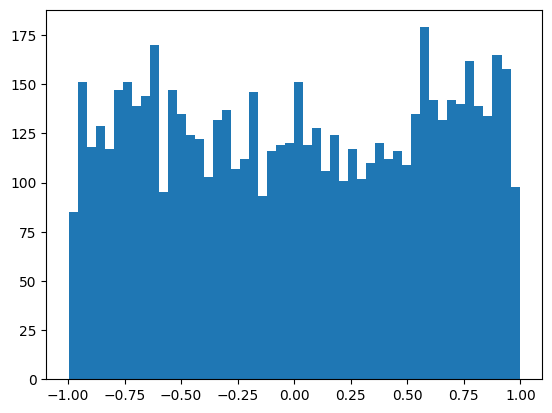

In [83]:
plt.hist(h.view(-1).tolist(), 50)

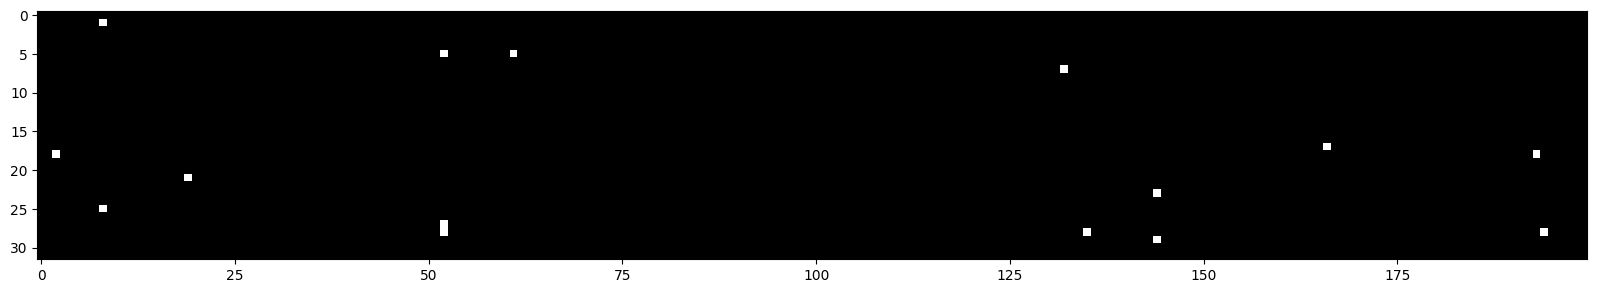

In [84]:
plt.figure(figsize = (20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

In [ ]:
with torch.no_grad():
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [20]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
	}[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    #hpreact = bngain * ((hpreact - hpreact.mean(0, keepdim=True))/hpreact.std(0, keepdim=True)) + bnbias
    hpreact = bngain * ((hpreact - bnmean_running)/bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')
    


train 2.0674192905426025
val 2.105670928955078


In [15]:
W1.shape

torch.Size([30, 200])

In [49]:
Xb.shape

torch.Size([32, 3])

In [50]:
emb.shape[0]

32

In [51]:
embcat.shape

torch.Size([32, 30])

In [52]:
emb.shape

torch.Size([32, 3, 10])

In [11]:
torch.nn.init.calculate_gain('relu')  # formula to calculate gain


1.4142135623730951